<a href="https://colab.research.google.com/github/rghimre3/INFO5502-Summer2022/blob/main/lab_assignment_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The sixth Lab-assignment (08/02/2022 11:59'AM' - 08/05/2022 11:59PM, 50 points in total)

The purpose of this exercise is to build a simple predicition model which can helpyou understand the workflow of machine learning. 

### Q1 Task Decription (50 Points)

The goal of this assignment is to predict bike share use, given the hour, day, and information about the weather. Companies like Divvy try to predict how much demand there will be for bikes on any given day to allocate resources to redistribute bikes so that, ideally, very few bike stations are ever full (when you can’t park your bike) or empty (when you can’t pick up a bike if you want to).

The data (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06) in Github provides detailed information on the data set and necessary downloads.

### Data Description

You are provided hourly rental data spanning two years (link: https://github.com/suthapalliuday/INFO5502-Summer2022/tree/main/datasets/lab_assignment_06). For this task, the training set is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or its components "casual" and "registered".

Data Fields

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1 - Clear, Few clouds, Partly cloudy, Partly cloudy

2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Output

Submission Format

Your output (a separate file) must have a header line and should be structured in the following format:

 datetime,count
 
 2011-01-20 00:00:00,0 
 
 2011-01-20 01:00:00,0
 
 2011-01-20 02:00:00,0
 
 ...
 
The tutorial code should demonstrate how to generate such a file from a very simple prediction model. Note, these prediction are to be done on the test file under the data tab, where you do not know the actual count, and should match the rows of the test file in count and order.

Your predictions should be compared to the ground truth information (sample_prediction.csv). Score are calculated using Root Mean Squared Error (RMSE).

### Tips

●	Add features: Pick columns/features from the data you already have. Or make a new feature from the ones you have. For example, the tutorial makes ‘hour’ from the datetime stamp, which seemed very useful. How about ‘month’?

●	Model selection: Try different models. Make sure they are regression models rather than classification models. Tip: random forest regression is a good, all around modeling strategy on complicated data sets.

●	Model tuning: Almost all regression models have parameters to tune (“hyperparameters”). E.g. polynomial regression has the degree of the polynomial (n = 1 for a line, n=2 for a quadratic fit, n=3 for a cubic fit…). Generally, one extreme makes the model too simple (e.g. a line for a curved set of points) and the other extreme makes the model overfit/be too complex, and usually the right choice is in between. For some models it is obvious what to tune (e.g. k for k nearest neighbors regression) and some don’t need much tuning with defaults that often work well. e.g. try changing the number of trees used in the random forest model!

●	Cross validation: The tutorial has a simple way of separating training and test data, however, there are better ways of splitting training and test data. Look into cross validation techniques, which are more reliable than an arbitrary split of training and test data.

●	Separate models for ...: Notice that count comes from just adding casual riders and registered riders. However, what if these two types of riders acted very differently? It might make sense to make two separate models and just add the results of both models together. This is also true for any subsets of your data that may behave wildly differently (e.g. create a separate model for each season?)

### Your code

In [2]:
### You code here:
import pandas as pd
import numpy as np
import csv as csv
import os 
import seaborn as sns
from datetime import datetime
from numpy.random import shuffle
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline

#dataframe for bike share data 
df = pd.read_csv("https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/lab_assignment_06/train_luc.csv")
df.head()



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9174 entries, 0 to 9173
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    9174 non-null   object 
 1   season      9174 non-null   int64  
 2   holiday     9174 non-null   int64  
 3   workingday  9174 non-null   int64  
 4   weather     9174 non-null   int64  
 5   temp        9174 non-null   float64
 6   atemp       9174 non-null   float64
 7   humidity    9174 non-null   int64  
 8   windspeed   9174 non-null   float64
 9   casual      9174 non-null   int64  
 10  registered  9174 non-null   int64  
 11  count       9174 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 860.2+ KB
None


In [4]:
print(df.describe())

            season      holiday   workingday      weather         temp  \
count  9174.000000  9174.000000  9174.000000  9174.000000  9174.000000   
mean      2.505559     0.031284     0.678875     1.414868    20.130401   
std       1.116618     0.174094     0.466934     0.635363     7.940504   
min       1.000000     0.000000     0.000000     1.000000     0.820000   
25%       2.000000     0.000000     0.000000     1.000000    13.940000   
50%       3.000000     0.000000     1.000000     1.000000    20.500000   
75%       4.000000     0.000000     1.000000     2.000000    27.060000   
max       4.000000     1.000000     1.000000     4.000000    41.000000   

             atemp     humidity    windspeed       casual   registered  \
count  9174.000000  9174.000000  9174.000000  9174.000000  9174.000000   
mean     23.578433    61.715064    12.737931    35.713647   154.868106   
std       8.617957    19.401829     8.199027    49.667738   150.981155   
min       0.760000     0.000000     0

In [5]:
# Adding datetime stamp
df['datetime']=pd.to_datetime(df.datetime)
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


In [6]:
# Adding season breakdown
df['season'] = df['season'].replace(1,'Spring')
df['season'] = df['season'].replace(2,'Summer')
df['season'] = df['season'].replace(3,'Fall')
df['season'] = df['season'].replace(4,'Winter')
df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,Spring,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1,1
1,2011-01-01 01:00:00,Spring,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1
2,2011-01-01 02:00:00,Spring,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,1,1
3,2011-01-01 03:00:00,Spring,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,1,1
4,2011-01-01 04:00:00,Spring,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,1,1
5,2011-01-01 05:00:00,Spring,0,0,2,9.84,12.880,75,6.0032,0,1,1,5,1,1
6,2011-01-01 06:00:00,Spring,0,0,1,9.02,13.635,80,0.0000,2,0,2,6,1,1
7,2011-01-01 07:00:00,Spring,0,0,1,8.20,12.880,86,0.0000,1,2,3,7,1,1
8,2011-01-01 08:00:00,Spring,0,0,1,9.84,14.395,75,0.0000,1,7,8,8,1,1
9,2011-01-01 09:00:00,Spring,0,0,1,13.12,17.425,76,0.0000,8,6,14,9,1,1


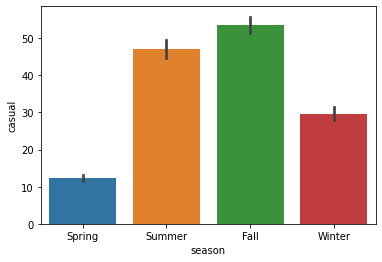

In [7]:
sns.barplot(x ='season', y ='casual', data = df, palette ='tab10')


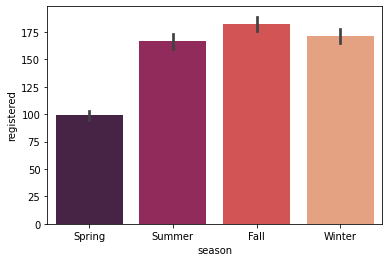

In [8]:
sns.barplot(x ='season', y ='registered', data = df, palette ='rocket')


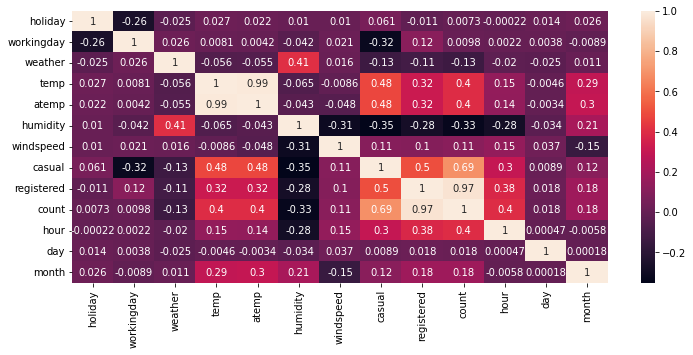

In [9]:
corr=df.corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr,annot=True)

In [10]:
df['month'] = pd.DatetimeIndex(df['datetime']).month
month = np.unique(df['month'])
print("month:",month)

month: [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [11]:


# picking features
cols = ['month', 'weather']

# pick one by commenting/uncommenting
model = RandomForestRegressor(n_estimators = 500)

print("columns selected for later:",cols)
print(model) 

columns selected for later: ['month', 'weather']
RandomForestRegressor(n_estimators=500)


In [13]:
#splitting training and testing 

# get number of rows in the training set
n = len(df) 
training_size = 0.75 
# set up separate training and testing sets using shuffled array indices
indices = np.array(range(n))
shuffle(indices)
split_point = int(n*training_size)
mytrain_i = indices[0:split_point]
mytest_i = indices[split_point:]


train_df = df.iloc[mytrain_i]
test_df = df.iloc[mytest_i]

print("samples in the new training subset:",len(train_df))
print("samples in the new test subset:",len(test_df))

samples in the new training subset: 6880
samples in the new test subset: 2294


In [14]:
# fit the model to the training subset of original training data
model.fit(train_df[cols], train_df['count'])

# predict on the testing subset of the original training data
pred_count = model.predict(test_df[cols])

# score the model on the new test set
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(test_df['count'],pred_count))
print("RMS error:",rms)

RMS error: 166.48534071343943


In [16]:
# reading test and sample data 
test_df = pd.read_csv('https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/lab_assignment_06/test_luc.csv')
print("\nNumber of samples:",test_df.shape[0] ,"and number of features:",test_df.shape[1],"\n")
sample_prediction = pd.read_csv('https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/lab_assignment_06/sample_prediction.csv', header=0)

# add new feature into the test data too, to use it in prediction
test_df['month'] = pd.DatetimeIndex(test_df['datetime']).month

# fit the selected model and apply to the test data
model.fit( train_df[cols], train_df['count'])
predicted_count = model.predict(test_df[cols])

model.fit( train_df[cols], train_df['registered'])
predicted_registered = model.predict(test_df[cols])

model.fit( train_df[cols], train_df['casual'])
predicted_casual = model.predict(test_df[cols])

# add the prediction column (in case you want to inspect it later)
test_df['count'] = predicted_count
test_df['registered'] = predicted_registered
test_df['casual'] = predicted_casual

rms_a = np.sqrt(mean_squared_error(sample_prediction['count'],predicted_casual+predicted_registered))
print("RMS error:",rms_a)

rms_b = np.sqrt(mean_squared_error(sample_prediction['count'],predicted_count))
print("RMS error:",rms_b)

# save the predicted count as a csv with a header column and datetime row
test_df = test_df[['datetime','count']].to_csv('my_prediction.csv', 
    index=False, header=True)

print("Prediction complete and saved")


Number of samples: 1712 and number of features: 9 

RMS error: 140.95370356356682
RMS error: 140.87341326900565
Prediction complete and saved


 Question 2 (20 points) Build a regession model to predict the change in price of the stock overtime. It can either be linear regression or non-linear regression. You can download the dataset from here: https://github.com/suthapalliuday/INFO5502-Summer2022/blob/main/datasets/portfolio_data.csv. The implementation of the LSTM on this same dataset was posted here as an reference: https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook

 ### Your code

In [ ]:
### You code here:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df = pd.read_csv("https://raw.githubusercontent.com/suthapalliuday/INFO5502-Summer2022/main/datasets/portfolio_data.csv")
df.head()

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1520 non-null   object 
 1   AMZN    1520 non-null   float64
 2   DPZ     1520 non-null   float64
 3   BTC     1520 non-null   float64
 4   NFLX    1520 non-null   float64
dtypes: float64(4), object(1)
memory usage: 59.5+ KB
None
              AMZN          DPZ           BTC         NFLX
count  1520.000000  1520.000000   1520.000000  1520.000000
mean    821.541810   146.771695   2421.465669   147.668273
std     518.442653    72.192287   3310.894199   107.641486
min     248.229996    51.190983     69.660004    29.464285
25%     364.360001    84.993593    340.904999    62.851071
50%     686.459992   127.168053    625.304993   104.000000
75%    1121.287536   202.454994   3874.912415   192.207496
max    2039.510010   298.635986  18972.320310   418.970001


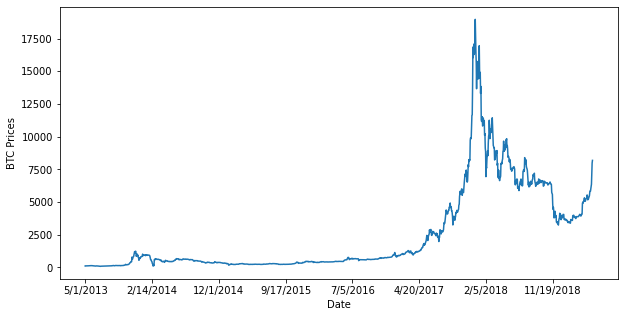

In [ ]:
df=df.set_index('Date')
df = df[['BTC']]
df= df.dropna() 

df.BTC.plot(figsize=(10,5)) 
plt.ylabel("BTC Prices")
plt.show()

In [ ]:
#moving averages for past 5 days and 10 days
df['S_5'] = df['BTC'].shift(1).rolling(window=5).mean() 
df['S_10']= df['BTC'].shift(1).rolling(window=10).mean() 
df= df.dropna() 
X = df[['S_5','S_10']] 
X.head()

,S_5,S_10
Date,,
5/15/2013,114.352,111.181000
5/16/2013,115.434,112.377000
5/17/2013,116.594,114.917000
5/20/2013,118.108,115.947999
5/21/2013,120.406,117.277000


In [ ]:
#Split data by 0.8

y = df['BTC']
t=.8 
t = int(t*len(df)) 

# Train dataset 
X_train = X[:t] 
y_train = y[:t]  

# Test dataset 
X_test = X[t:] 
y_test = y[t:]

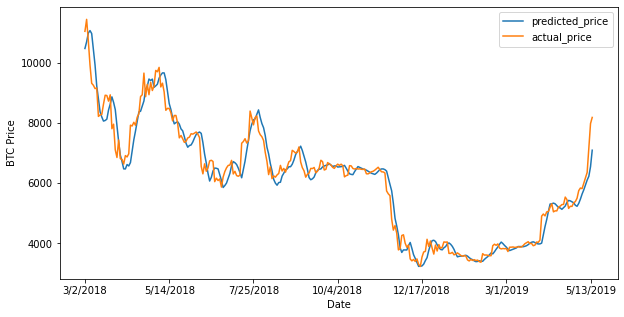

In [ ]:
linear = LinearRegression().fit(X_train,y_train)
predicted_price = linear.predict(X_test)  
predicted_price = pd.DataFrame(predicted_price,index=y_test.index,columns = ['BTC'])  
predicted_price.plot(figsize=(10,5))  
y_test.plot()  
plt.legend(['predicted_price','actual_price'])  
plt.ylabel("BTC Price")  
plt.show()